# Code for plotting light curves (once we know TIC ID #)

In [2]:
import os
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"

import lightkurve as lk
from lightkurve import search_tesscut
from astropy.timeseries import BoxLeastSquares
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*tpfmodel submodule.*")

print("Lightkurve version:", lk.__version__)

Lightkurve version: 2.5.1


# Download data for specific TIC ID

In [32]:
# choose target using TIC
target = "TIC 279741379"  # change as needed 
nickname = "TOI-186"       # change as needed
print(f"\nSearching for {target} (nickname: {nickname})") 

search = lk.search_tesscut(target)
search

# Download all available sectors
tpfs = search.download_all(cutout_size=5)
print(f"\nDownloaded {len(tpfs)} sectors for this star.")


Searching for TIC 279741379 (nickname: TOI-186)

Downloaded 16 sectors for this star.


In [26]:
lc_list = []

for tpf in tpfs:
    try:
        print(f"\nProcessing Sector {tpf.sector}...")
        
        # Check if TPF contains flux
        if tpf.flux.size == 0:
            print("TPF is empty --> skipping")
            continue
        
        # Create aperture mask
        mask = tpf.create_threshold_mask(threshold=3)
        lc = tpf.to_lightcurve(aperture_mask=mask)
        
        # Remove NaN values
        lc = lc.remove_nans()
        
        # Check if enough data points remain
        if len(lc.time) < 500:
            print(f"Light curve too short ({len(lc.time)} points) --> skipping")
            continue
        
        # Flatten to remove stellar variability
        lc = lc.flatten(window_length=301)
        lc_list.append(lc)
        print(f"Successfully processed {len(lc.time)} data points")
        
    except Exception as e:
        print(f"Error in sector {tpf.sector}: {e}")
        continue

print(f"Successfully extracted {len(lc_list)} light curves")


Processing Sector 4...
Successfully processed 1027 data points

Processing Sector 3...
Successfully processed 1077 data points

Processing Sector 1...
Successfully processed 1267 data points

Processing Sector 2...
Successfully processed 1196 data points

Processing Sector 30...
Successfully processed 3681 data points

Processing Sector 28...
Successfully processed 3449 data points

Processing Sector 29...
Successfully processed 3572 data points

Processing Sector 34...
Successfully processed 3474 data points

Processing Sector 68...
Successfully processed 11532 data points

Processing Sector 61...
Successfully processed 10653 data points

Processing Sector 69...
Successfully processed 9735 data points

Processing Sector 64...
Successfully processed 11276 data points

Processing Sector 95...


Successfully processed 10069 data points

Processing Sector 96...
Successfully processed 10337 data points

Processing Sector 88...
Light curve too short (0 points) --> skipping

Processing Sector 97...
Successfully processed 22640 data points
Successfully extracted 15 light curves


<Figure size 1400x400 with 0 Axes>

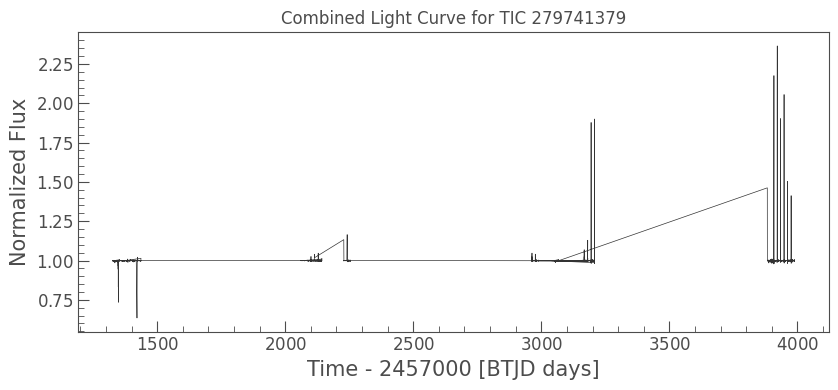


Total time baseline: 2577.4 days
Total data points: 104985


In [27]:
# combine sectors into one light curve
if len(lc_list) == 0:
    raise ValueError("No valid light curves extracted. Try a different target.")

all_lc = lc_list[0]
for lc in lc_list[1:]:
    all_lc = all_lc.append(lc)

all_lc = all_lc.normalize()

# Plot the combined light curve
plt.figure(figsize=(14, 4))
all_lc.plot()
plt.title(f"Combined Light Curve for {target}")
plt.tight_layout()
plt.show()

print(f"\nTotal time baseline: {all_lc.time.value[-1] - all_lc.time.value[0]:.1f} days")
print(f"Total data points: {len(all_lc.time)}")

In [28]:
# run Box Least Squares (BLS) periodogram
time = all_lc.time.value
flux = all_lc.flux.value
flux_error = all_lc.flux_err.value

# parameters for BLS
period_min = 1        # days
period_max = 120      # days
n_periods = 20000     # number of periods to test

duration_min = 0.05   # min transit duration, days
duration_max = 0.4    # max transit duration, days
n_durations = 10      # num of duration to test

print("Running BLS search (may take awhile)")
print(f"Period range: {period_min} - {period_max} days")
print(f"Duration range: {duration_min} - {duration_max} days")

# create BLS model
model = BoxLeastSquares(time, flux, flux_error)

# period and duration grids
periods = np.linspace(period_min, period_max, n_periods)
durations = np.linspace(duration_min, duration_max, n_durations)

# run BlS model
bls_result = model.power(periods, durations)

# get best-fit parameters from model
best_index = np.argmax(bls_result.power)
best_period = bls_result.period[best_index]
best_duration = bls_result.duration[best_index]
best_t0 = bls_result.transit_time[best_index]
best_power = bls_result.power[best_index]
best_depth = bls_result.depth[best_index]

print("\nFinished BLS search")
print("Best candidate:")
print(f"     Period: {best_period:.4f} days")
print(f"     Duration: {best_duration:.4f} days ({best_duration*24:.2f} hours)")
print(f"     Transit time (t0): {best_t0:.4f}")
print(f"     BLS Power: {best_power:.4f}")
print(f"     Transit depth: {best_depth*1e6:.1f} ppm")

Running BLS search (may take awhile)
Period range: 1 - 120 days
Duration range: 0.05 - 0.4 days

Finished BLS search
Best candidate:
     Period: 106.0882 days
     Duration: 0.3200 days (7.68 hours)
     Transit time (t0): 1421.3951
     BLS Power: 242556675.0222
     Transit depth: 272864.4 ppm


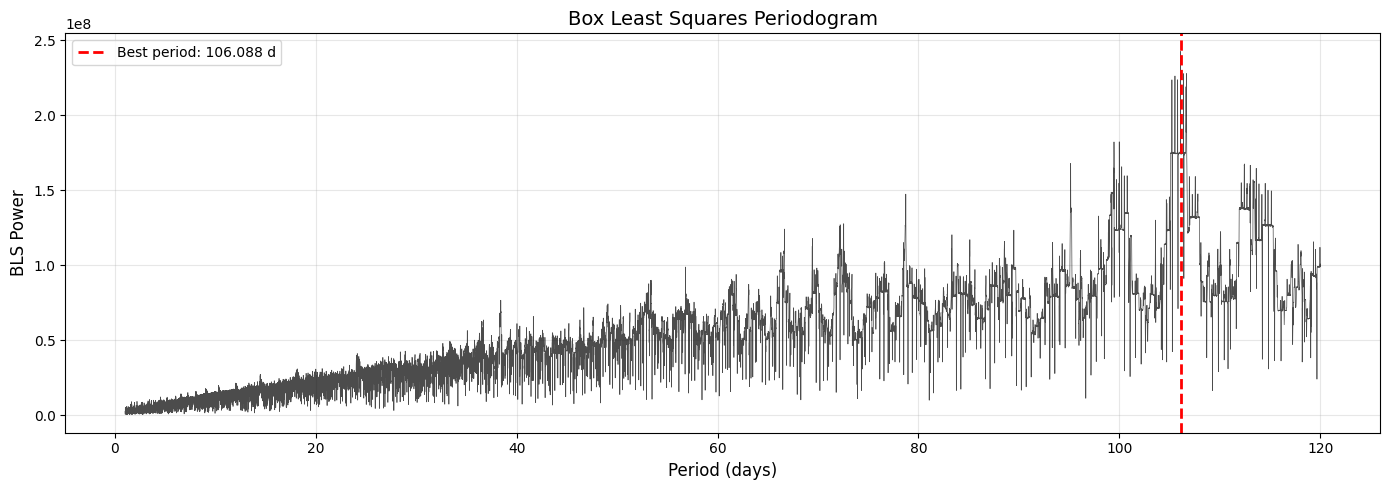

In [29]:
# plot BLS periodogram
plt.figure(figsize=(14, 5))
plt.plot(bls_result.period, bls_result.power, 'k-', lw=0.5, alpha=0.7)
plt.axvline(best_period, color='red', linestyle='--', lw=2, label=f'Best period: {best_period:.3f} d')
plt.xlabel("Period (days)", fontsize=12)
plt.ylabel("BLS Power", fontsize=12)
plt.title("Box Least Squares Periodogram", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

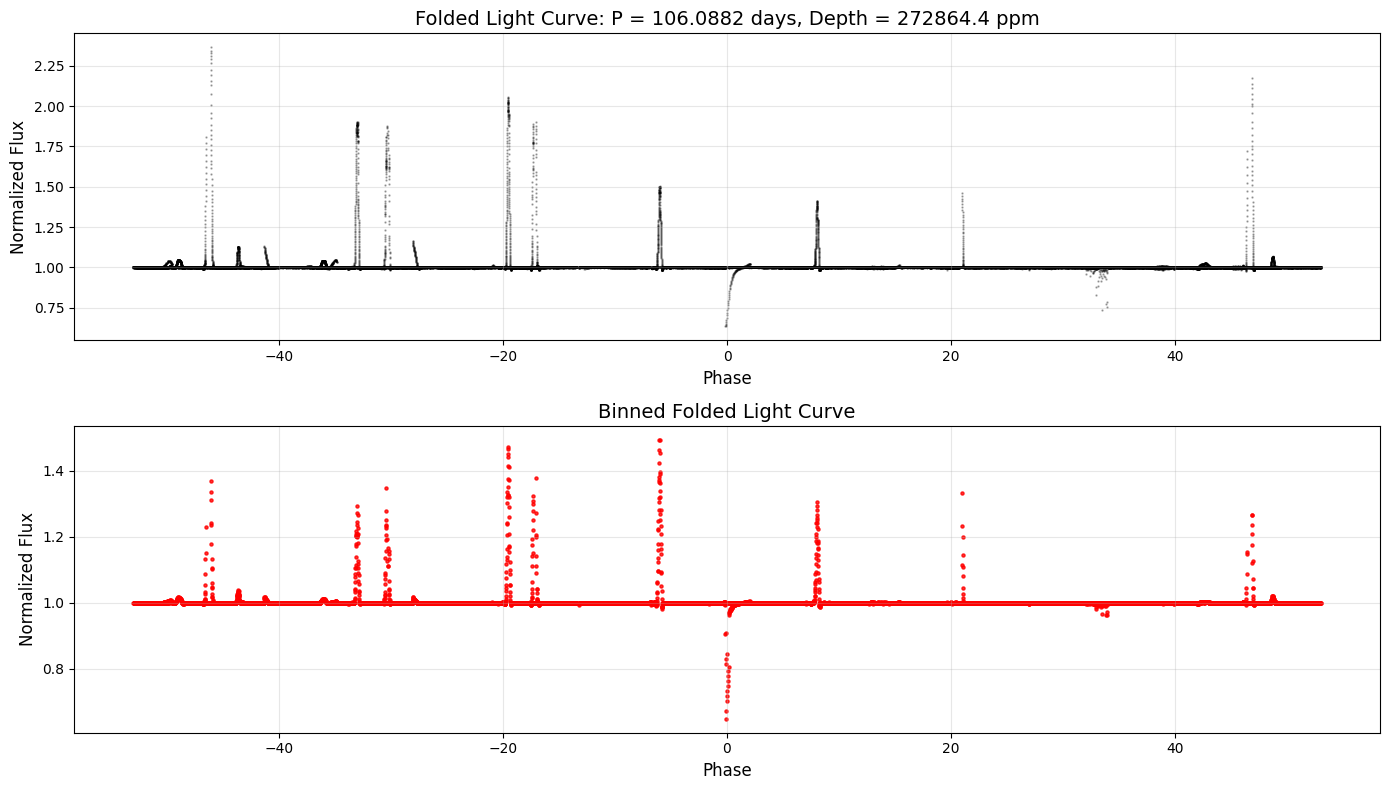

In [30]:
# fold light curve at best period
lc_fold = all_lc.fold(period=best_period, epoch_time=best_t0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# scatter plot of folded light curve
lc_fold.scatter(ax=ax1, s=2, alpha=0.3, c='black')
ax1.set_title(f"Folded Light Curve: P = {best_period:.4f} days, Depth = {best_depth*1e6:.1f} ppm", fontsize=14)
ax1.set_xlabel("Phase", fontsize=12)
ax1.set_ylabel("Normalized Flux", fontsize=12)
ax1.grid(alpha=0.3)

# binned version (migth be more clear)
lc_fold_binned = lc_fold.bin(time_bin_size=0.01)
lc_fold_binned.scatter(ax=ax2, s=20, c='red', alpha=0.8)
ax2.set_title("Binned Folded Light Curve", fontsize=14)
ax2.set_xlabel("Phase", fontsize=12)
ax2.set_ylabel("Normalized Flux", fontsize=12)
ax2.grid(alpha=0.3)

plt.tight_layout()   # ensures all elements fit in figure
plt.show()

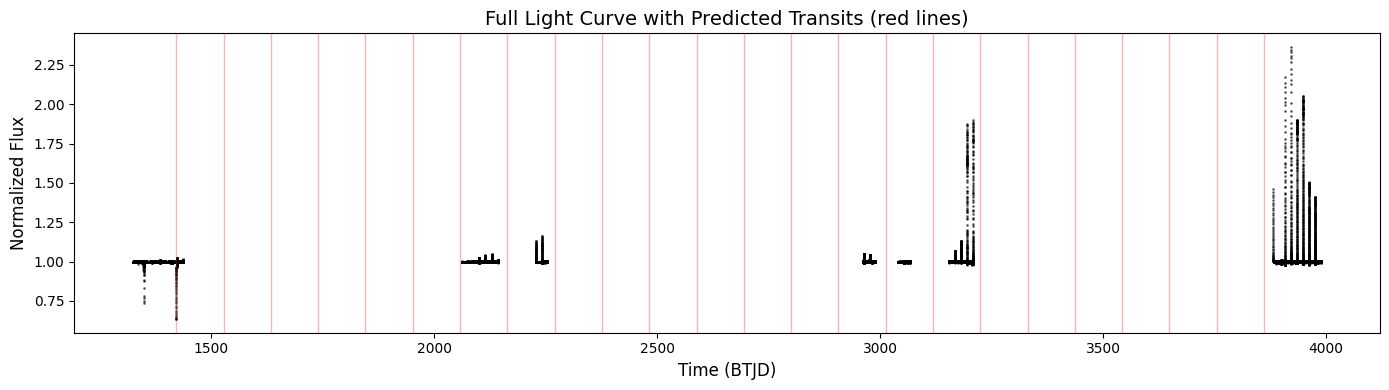


Expected number of transits: ~24


In [31]:
# show individual transits in time series
# calc transit times
time_baseline = time[-1] - time[0]
n_transits = int(time_baseline / best_period)
transit_times = best_t0 + best_period * np.arange(n_transits)

# plot light curve with transit markers
plt.figure(figsize=(14, 4))
plt.plot(time, flux, 'k.', ms=2, alpha=0.5)
for tt in transit_times:
    if time[0] <= tt <= time[-1]:
        plt.axvline(tt, color='red', alpha=0.3, lw=1)
plt.xlabel("Time (BTJD)", fontsize=12)
plt.ylabel("Normalized Flux", fontsize=12)
plt.title(f"Full Light Curve with Predicted Transits (red lines)", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nExpected number of transits: ~{n_transits}")